# **Projet de Valorisation financiere**

## **Partie II**

**Description**:

Le projet consiste à évaluer la valeur actuarielle d’un produit de rente variable souscrit par un assuré.

Ce produit combine des éléments d’assurance vie (avec un taux de mortalité) et de finance (fonds investi dans un actif risqué avec un retrait annuel garanti).

L’évaluation se fera par deux méthodes principales :

1. **Arbre binomial** (binomial tree) pour approximer le processus stochastique.

2. **Simulation Monte-Carlo** pour vérifier et comparer les résultats.

## **Arbre binomiale**

In [ ]:
# Importation des packages du projet

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gmwb_binomial_tree(S0, r, sigma, T, n, K, mortalite, gamma):
    dt = T / n
    u = np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
    d = np.exp((r - 0.5 * sigma**2) * dt - sigma * np.sqrt(dt))

    p = (np.exp(r * dt) - d) / (u - d)

    S = np.zeros((n+1, n+1))
    S[0, 0] = S0
    for i in range(1, n+1):
        for j in range(i+1):
            if j == 0:
                S[i, j] = S[i-1, j] * u
            else:
                S[i, j] = S[i-1, j-1] * d

    A = (S0 / S0) * (1 - gamma) ** T

    # Valeur de l'option européenne : max(S_T - K/A, 0)
    H = np.maximum(0, S[n, :n+1] - K / A)

    # Backward induction sur H
    for i in range(n-1, -1, -1):
        for j in range(i+1):
            H[j] = np.exp(-r * dt) * (p * H[j] + (1 - p) * H[j+1])

    discount = lambda t: np.exp(-r * t)
    surv = lambda t: np.exp(-mortalite * t)

    part_fix = 0

    for k in range(1, T):
        t = k
        part_fix += surv(t) * (1 - gamma) ** k

    part_fix *= gamma * S0

    part_alea = discount(T) * surv(T) * (K + A * H[0])

    V0 = part_fix + part_alea
    return V0


V0 = gmwb_binomial_tree(S0=250_000, r=0.03, sigma=0.19, T=10, n=200*10, K=100_000, mortalite=0.00008, gamma=0.1)
print(f"Valeur actuarielle du contrat : {V0:,.2f} €")

Valeur actuarielle du contrat : 231,240.53 €


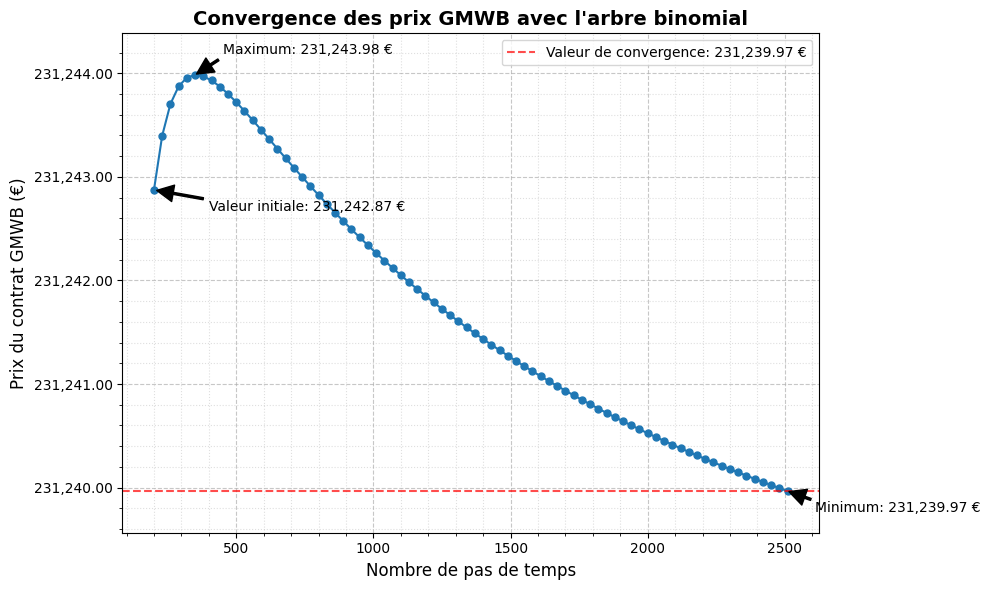

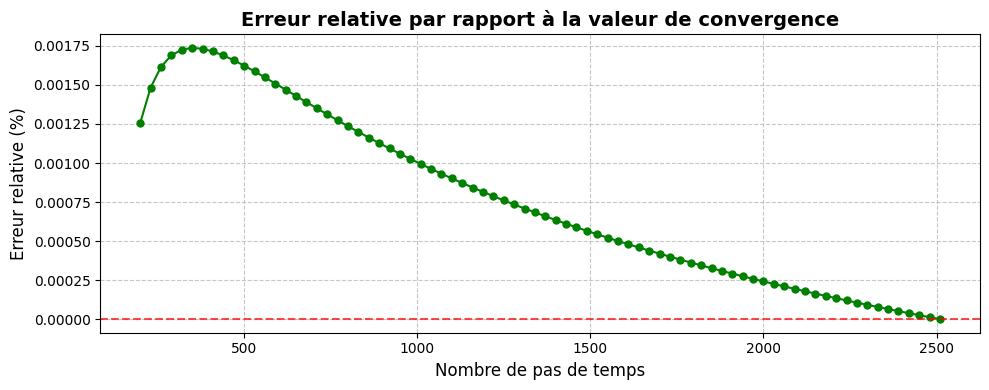

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Utiliser votre plage de pas de temps
n_steps = list(range(200, 2521, 30))
prices = [gmwb_binomial_tree(S0=250_000, r=0.03, sigma=0.19, T=10, n=n, K=100_000, mortalite=0.00008, gamma=0.1) for n in n_steps]

# Création d'une figure avec une taille appropriée
plt.figure(figsize=(10, 6))

# Traçage du graphique avec des points bleus reliés
plt.plot(n_steps, prices, marker='o', linestyle='-', color='#1f77b4', markersize=5)

convergence_value = prices[-1]
plt.axhline(y=convergence_value, color='red', linestyle='--', alpha=0.7,
            label=f'Valeur de convergence: {convergence_value:,.2f} €')

price_range = max(prices) - min(prices)
# Ajustement plus serré de l'échelle des ordonnées pour amplifier les fluctuations
plt.ylim(min(prices) - price_range*0.1, max(prices) + price_range*0.1)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))

plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()  # Ajouter des graduations mineures
plt.grid(which='minor', linestyle=':', alpha=0.4)  # Grille plus fine

plt.xlabel("Nombre de pas de temps", fontsize=12)
plt.ylabel("Prix du contrat GMWB (€)", fontsize=12)
plt.title("Convergence des prix GMWB avec l'arbre binomial", fontsize=14, fontweight='bold')


max_price_idx = np.argmax(prices)
min_price_idx = np.argmin(prices)
first_price_idx = 0

# Annoter le maximum
plt.annotate(f'Maximum: {prices[max_price_idx]:,.2f} €',
             xy=(n_steps[max_price_idx], prices[max_price_idx]),
             xytext=(n_steps[max_price_idx]+100, prices[max_price_idx] + price_range*0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Annoter le minimum (s'il ne s'agit pas du premier point)
if min_price_idx != first_price_idx:
    plt.annotate(f'Minimum: {prices[min_price_idx]:,.2f} €',
                xy=(n_steps[min_price_idx], prices[min_price_idx]),
                xytext=(n_steps[min_price_idx]+100, prices[min_price_idx] - price_range*0.05),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                fontsize=10)

# Annoter le premier point
plt.annotate(f'Valeur initiale: {prices[first_price_idx]:,.2f} €',
             xy=(n_steps[first_price_idx], prices[first_price_idx]),
             xytext=(n_steps[first_price_idx]+200, prices[first_price_idx] - price_range*0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Ajout d'une légende
plt.legend()

# Amélioration des marges et affichage
plt.tight_layout()
plt.show()

# Graphique supplémentaire montrant l'erreur relative (en pourcentage)
plt.figure(figsize=(10, 4))
relative_errors = [(p - convergence_value)/convergence_value * 100 for p in prices]
plt.plot(n_steps, relative_errors, marker='o', linestyle='-', color='green', markersize=5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Nombre de pas de temps", fontsize=12)
plt.ylabel("Erreur relative (%)", fontsize=12)
plt.title("Erreur relative par rapport à la valeur de convergence", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **Methode de Monte Carlos**

## **Utilisation de la méthode de discretisation des aires**

In [ ]:
def gmwb_monte_carlo_premium(S0, sigma, r, T, mortalite, N, gamma, m, K):
    dt = T / m
    discount = lambda t: np.exp(-r * t)
    surv = lambda t: np.exp(-mortalite * t)

    liste_payoffs = []
    A = (S0 / S0) * (1 - gamma) ** T
    for _ in range(N):
        S_path = [S0]
        for j in range(1, m + 1):
            Sj_prev = S_path[-1]
            epsilon = np.random.normal()
            dS = r * Sj_prev * dt + sigma * Sj_prev * np.sqrt(dt) * epsilon
            Sj = Sj_prev + dS
            S_path.append(Sj)

        S_T = S_path[-1]

        payoff = max(S_T - K / A, 0)

        liste_payoffs.append(payoff)


    part_fix = sum([surv(k) * (1 - gamma) ** k for k in range(1, T)])

    part_fix *= gamma * S0

    mean_payoff = np.mean(liste_payoffs)

    part_alea = discount(T) * surv(T) * (K + A * mean_payoff)

    V0 = part_fix + part_alea

    return V0


V0 = gmwb_monte_carlo_premium(S0=250_000, sigma=0.19, r=0.03, T=10,
                               mortalite=0.00008, N=10000, gamma=0.1, m=2520, K=100_000)

print(f"Valeur actuarielle du contrat (Monte Carlo) : {V0:,.2f} €")

Valeur actuarielle du contrat (Monte Carlo) : 238,058.12 €


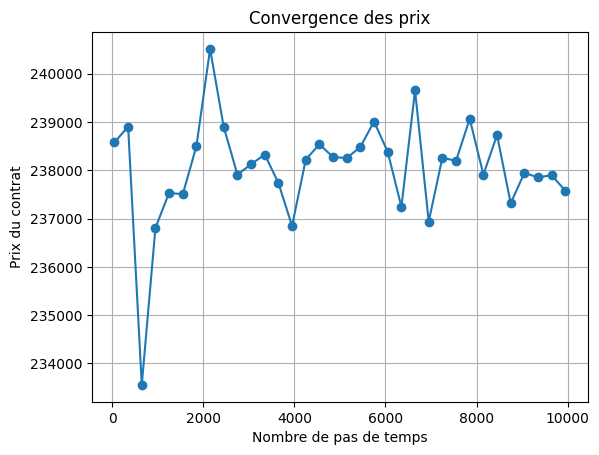

In [ ]:
N_list = range(50,10000,100)

price = [gmwb_monte_carlo_premium(S0=250_000, sigma=0.19, r=0.03, T=10,
                               mortalite=0.00008, N=n, gamma=0.1, m=100, K=100_000) for n in N_list]

plt.plot(N_list, price, marker='o')

plt.xlabel("Nombre de pas de temps")

plt.ylabel("Prix du contrat")

plt.title("Convergence des prix")

plt.grid()

plt.show()

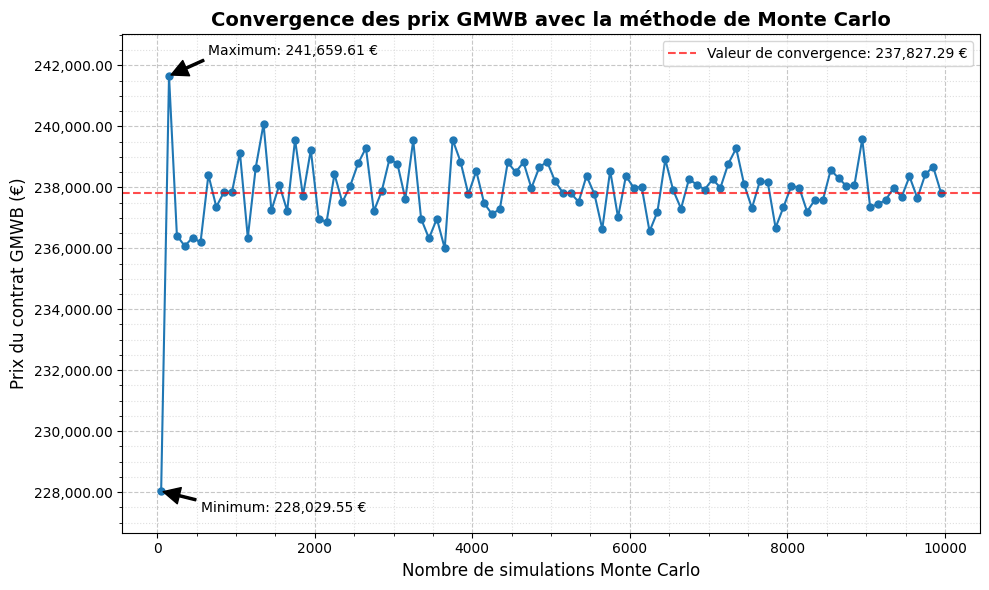

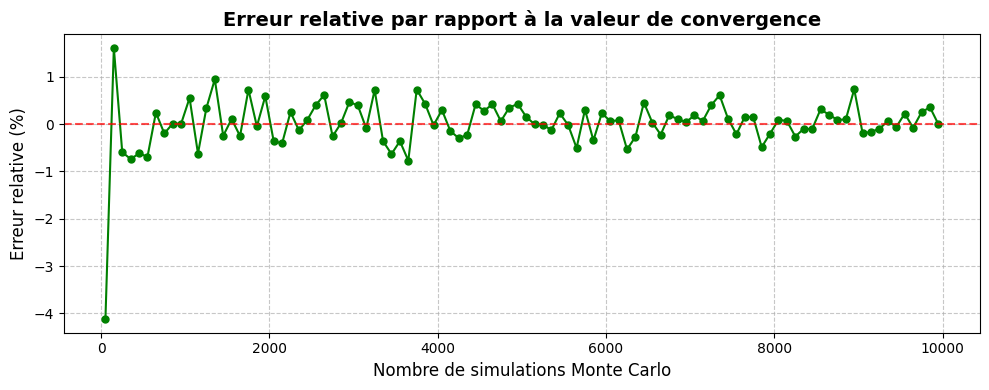

In [ ]:
N_list = range(50, 10000, 100)

# Calcul des prix
price = [gmwb_monte_carlo_premium(S0=250_000, sigma=0.19, r=0.03, T=10,
                              mortalite=0.00008, N=n, gamma=0.1, m=100, K=100_000) for n in N_list]

# Création d'une figure avec une taille appropriée
plt.figure(figsize=(10, 6))

# Traçage du graphique avec des points bleus reliés
plt.plot(N_list, price, marker='o', linestyle='-', color='#1f77b4', markersize=5)

# Valeur de convergence
convergence_value = price[-1]
plt.axhline(y=convergence_value, color='red', linestyle='--', alpha=0.7,
            label=f'Valeur de convergence: {convergence_value:,.2f} €')

# Calculer la plage pour ajuster l'échelle
price_range = max(price) - min(price)
plt.ylim(min(price) - price_range*0.1, max(price) + price_range*0.1)

# Formatage des étiquettes pour plus de précision
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))

# Amélioration de la grille
plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.4)

# Ajout des titres et étiquettes d'axes
plt.xlabel("Nombre de simulations Monte Carlo", fontsize=12)
plt.ylabel("Prix du contrat GMWB (€)", fontsize=12)
plt.title("Convergence des prix GMWB avec la méthode de Monte Carlo", fontsize=14, fontweight='bold')

# Annotations des points clés
max_price_idx = np.argmax(price)
min_price_idx = np.argmin(price)

# Annotation du maximum
plt.annotate(f'Maximum: {price[max_price_idx]:,.2f} €',
             xy=(N_list[max_price_idx], price[max_price_idx]),
             xytext=(N_list[max_price_idx]+500, price[max_price_idx] + price_range*0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Annotation du minimum
plt.annotate(f'Minimum: {price[min_price_idx]:,.2f} €',
            xy=(N_list[min_price_idx], price[min_price_idx]),
            xytext=(N_list[min_price_idx]+500, price[min_price_idx] - price_range*0.05),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            fontsize=10)

# Ajout d'une légende
plt.legend()

# Amélioration des marges et affichage
plt.tight_layout()
plt.show()

# Graphique d'erreur relative
plt.figure(figsize=(10, 4))
relative_errors = [(p - convergence_value)/convergence_value * 100 for p in price]
plt.plot(N_list, relative_errors, marker='o', linestyle='-', color='green', markersize=5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Nombre de simulations Monte Carlo", fontsize=12)
plt.ylabel("Erreur relative (%)", fontsize=12)
plt.title("Erreur relative par rapport à la valeur de convergence", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Deuxieme methode de discretisation**

In [ ]:
def gmwb_monte_carlo_premium_2(S0, sigma, r, T, mortalite, N, gamma, m, K):
    """
    Évaluation d'un contrat GMWB par simulation Monte Carlo log-normale.

    Parameters:
    -----------
    S0 : float
        Valeur initiale du fonds
    sigma : float
        Volatilité de l'actif
    r : float
        Taux sans risque
    T : int
        Maturité en années
    mortalite : float
        Taux de mortalité constant
    N : int
        Nombre de simulations
    gamma : float
        Taux de retrait annuel
    m : int
        Nombre de pas de temps
    K : float
        Capital minimum garanti
    Returns:
    --------
    float
        Valeur actuarielle du contrat
    """
    dt = T / m
    discount = lambda t: np.exp(-r * t)
    surv = lambda t: np.exp(-mortalite * t)

    # Facteur d'accumulation
    A = (1 - gamma) ** T

    # Simuler les trajectoires
    liste_payoffs = []
    for _ in range(N):
        # Initialiser le chemin de prix
        S_path = [S0]

        # Simuler le chemin avec la méthode d'Euler log-normale
        for j in range(1, m + 1):
            Sj_prev = S_path[-1]
            epsilon = np.random.normal()
            Sj = Sj_prev * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * epsilon)
            S_path.append(Sj)

        # Valeur finale
        S_T = S_path[-1]

        # Calculer le payoff
        payoff = max(S_T - K / A, 0)
        liste_payoffs.append(payoff)

    # Calculer la partie fixe (somme des retraits)
    part_fix = 0
    for k in range(1, T):
        part_fix += surv(k) * (1 - gamma)**(k)
    part_fix *= gamma * S0

    # Calculer la partie aléatoire (option européenne)
    mean_payoff = np.mean(liste_payoffs)
    part_alea = discount(T) * surv(T) * (K + A * mean_payoff)

    # Valeur totale du contrat
    V0 = part_fix + part_alea

    return V0

V0 = gmwb_monte_carlo_premium_2(
    S0=250_000,
    sigma=0.19,
    r=0.03,
    T=10,
    mortalite=0.00008,
    N=10000,
    gamma=0.1,
    m=252,
    K=100_000
)

print(f"Valeur actuarielle du contrat (Monte Carlo amélioré) : {V0:,.2f} €")

Valeur actuarielle du contrat (Monte Carlo amélioré) : 238,224.13 €


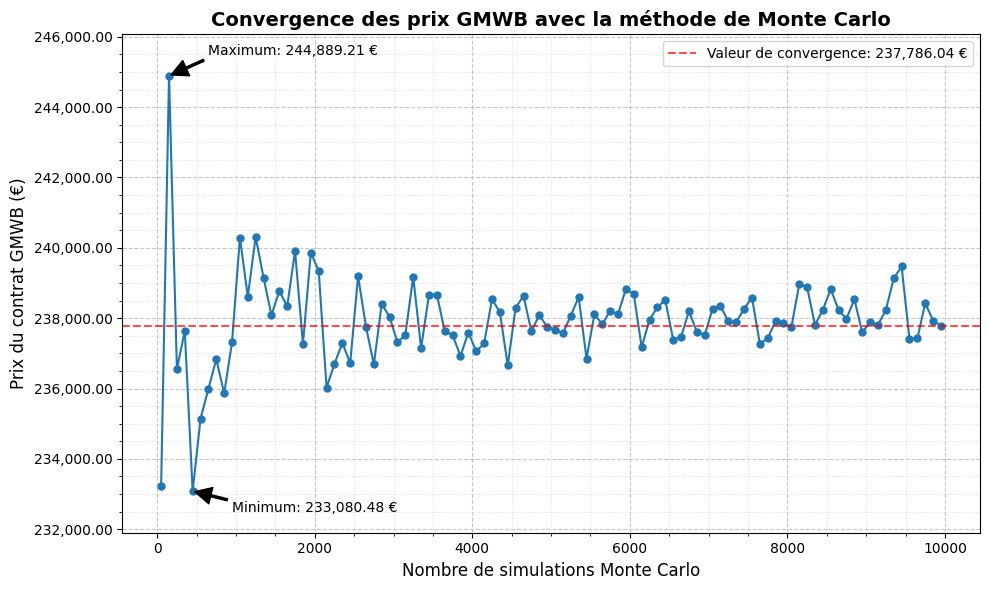

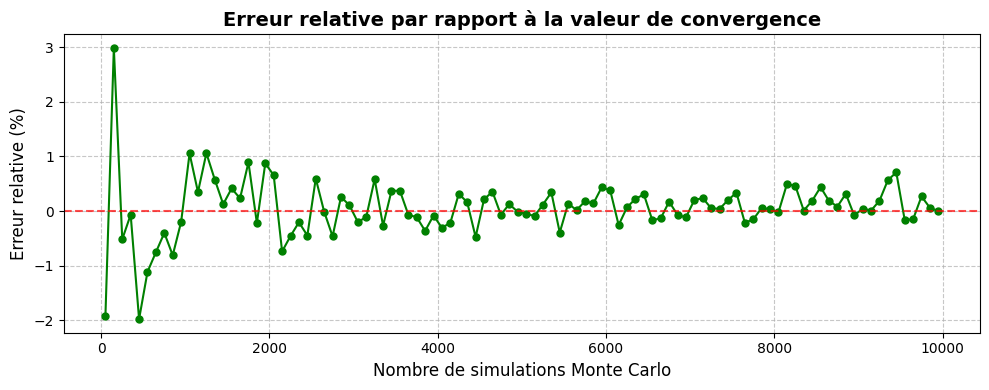

In [ ]:
N_list = range(50, 10000, 100)

# Calcul des prix
price = [gmwb_monte_carlo_premium_2(S0=250_000, sigma=0.19, r=0.03, T=10,
                              mortalite=0.00008, N=n, gamma=0.1, m=100, K=100_000) for n in N_list]

plt.figure(figsize=(10, 6))

# Traçage du graphique avec des points bleus reliés
plt.plot(N_list, price, marker='o', linestyle='-', color='#1f77b4', markersize=5)

# Valeur de convergence
convergence_value = price[-1]
plt.axhline(y=convergence_value, color='red', linestyle='--', alpha=0.7,
            label=f'Valeur de convergence: {convergence_value:,.2f} €')

# Calculer la plage pour ajuster l'échelle
price_range = max(price) - min(price)
plt.ylim(min(price) - price_range*0.1, max(price) + price_range*0.1)

# Formatage des étiquettes pour plus de précision
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))

# Amélioration de la grille
plt.grid(True, linestyle='--', alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.4)

# Ajout des titres et étiquettes d'axes
plt.xlabel("Nombre de simulations Monte Carlo", fontsize=12)
plt.ylabel("Prix du contrat GMWB (€)", fontsize=12)
plt.title("Convergence des prix GMWB avec la méthode de Monte Carlo", fontsize=14, fontweight='bold')

# Annotations des points clés
max_price_idx = np.argmax(price)
min_price_idx = np.argmin(price)

# Annotation du maximum
plt.annotate(f'Maximum: {price[max_price_idx]:,.2f} €',
             xy=(N_list[max_price_idx], price[max_price_idx]),
             xytext=(N_list[max_price_idx]+500, price[max_price_idx] + price_range*0.05),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
             fontsize=10)

# Annotation du minimum
plt.annotate(f'Minimum: {price[min_price_idx]:,.2f} €',
            xy=(N_list[min_price_idx], price[min_price_idx]),
            xytext=(N_list[min_price_idx]+500, price[min_price_idx] - price_range*0.05),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            fontsize=10)

# Ajout d'une légende
plt.legend()

# Amélioration des marges et affichage
plt.tight_layout()
plt.show()

# Graphique d'erreur relative
plt.figure(figsize=(10, 4))
relative_errors = [(p - convergence_value)/convergence_value * 100 for p in price]
plt.plot(N_list, relative_errors, marker='o', linestyle='-', color='green', markersize=5)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel("Nombre de simulations Monte Carlo", fontsize=12)
plt.ylabel("Erreur relative (%)", fontsize=12)
plt.title("Erreur relative par rapport à la valeur de convergence", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# **QUESTION 4**

In [ ]:
#Paramétrage de l'environnement de travail
#Fixation de la graine pour la reproductibilité
np.random.seed(123)

InterestRate = 3/100 # annual interest rate
NbTradingDay = 257 #number of trading days per year
Strike = 100000 # strike at maturity
Maturity = 10 #maturity of the product
InitialFunds = 250000 #initial value of the funds
MortalityRate = 0.08/100 #Mortality rate in the option purchaser population
Theta = 0 #initialisation of the part of stocks in the asset
gamma = 10/100

In [ ]:
#Montage du drive
from google.colab import files
files.upload()
#Importation des données
FileData = pd.read_excel("DATA.xlsx",sheet_name="Funds")

Saving DATA.xlsx to DATA.xlsx


In [ ]:
from pickle import TRUE
#Première visualisation des données
FileData
dataBase = FileData[["Unnamed: 1", "Unnamed: 2", "Unnamed: 3"]]
dataBase = dataBase.rename(columns={"Unnamed: 1":"Day", "Unnamed: 2":"Stocks", "Unnamed: 3":"Bonds"})
dataBase = dataBase.drop(0)
dataBase

,Day,Stocks,Bonds
1,1,100,100
2,2,99.649445,100.391948
3,3,99.90048,100.654631
4,4,99.463858,100.616933
5,5,99.001496,100.826072
...,...,...,...
396,396,134.181904,100.089403
397,397,134.155271,99.942142
398,398,133.374711,99.794663
399,399,135.16452,100.031697


In [ ]:
#Fonction de base pour les calculs

#Cette fonction calcule la probabilité de survie de l'individu jusqu'à l'horizon
def survie(horizon=1):
    return np.exp(-horizon*MortalityRate)

#Cette fonction calcule le facteur d'actualisation entre les instants 0 et l'horizon
def FacteurActualisation(horizon=1, Taux = InterestRate):
  return np.exp(-InterestRate*horizon)

#Cette fonction calcule la part cumulée du fonds non retirée
def GammaCumule(horizon=1):
  return (1-gamma)**horizon

Le calcul de la valeur actuelle repose sur deux parties, une déterministe et une autre stochastique dont la somme permet d'obtenir la prime à l'instant 0. Cette prime est donnée par:

$V_0 = \gamma F_0\sum\limits_{k=1}^{T-1} \, _kp_x (1-\gamma)^k+
  e^{-rT}\, _Tp_x \left(K_T + A \cdot\mathbf{E}^Q \left(\left(S_T - \frac{K_T}{A}\right)_{+} \mid \mathcal{F}_0\right)\right)  $

avec

$A = \dfrac{F_{0} \left( 1 - \gamma \right)^T}{S_{0}}$

La partie fixe est donnée par:$\gamma F_0
  \sum\limits_{k=1}^{T-1} \, _kp_x (1-\gamma)^k$ et la partie variable  est donnée par: $_TP_x\mathbb{E}^Q[e^{-rT}((F_T-K_T)_+|\mathcal{F}_0))]$

In [ ]:
#Calcul de la partie fixe de la prime

#Vecteur des probabilités de survie et du produit cumulé de l'épargne
somme = 0
for i in range(1,Maturity-1):
 somme =somme + survie(horizon=i)*GammaCumule(horizon=i)
PartieFixe = gamma*InitialFunds*somme
print("La partie fixe de la prime est:", PartieFixe)

La partie fixe de la prime est: 127740.43877576203


In [ ]:
#Estimation des rendements annuels moyens, des écart-types annuels moyens et de la corrélation entre les deux actifs
dataValue = dataBase[["Stocks", "Bonds"]]

#Calcul du facteur de correction sur base annuelle
delta =1/NbTradingDay

#Calcul du vecteur des rendements annuels.
gross_return = dataValue/dataValue.shift(1)
gross_return = gross_return.drop(1) #On efface la première ligne des rendements qui contient NaN
log_return = gross_return.applymap(np.log)

#Estimation du rendement moyen sur base annuelle
annual_return = (1/delta)*log_return.mean()
annual_return = np.array(annual_return)
annual_return

<ipython-input-8-b99dcdcb3159>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log_return = gross_return.applymap(np.log)


array([0.19592402, 0.00030134])

In [ ]:
#Estimation des volatilités sur base annuelle
annual_return_std = (1/np.sqrt(delta))*log_return.std()
annual_return_std = np.array(annual_return_std)
annual_return_std

array([0.22677423, 0.03939005])

In [ ]:
#Estimation de la matrice de covariance sur base annuelle et de sa décomposition de cholesky
return_corr = log_return.corr()
rho = return_corr.at["Bonds", "Stocks"]
stocks_std = annual_return_std[0]
bonds_std = annual_return_std[1]
cov_matrix  = np.array([[stocks_std**2, rho*stocks_std*bonds_std],[rho*stocks_std*bonds_std, bonds_std**2]])
sigma = np.linalg.cholesky(cov_matrix) #décomposition de Cholesky de la matrice de variance-covariance
sigma

array([[ 0.22677423,  0.        ],
       [-0.00317665,  0.03926175]])

In [ ]:
nb_jours = NbTradingDay*Maturity # nombre de jours sur lesquelles on simule les prix des différents jusqu'à maturité
nb_simulation = 10000 # nombre de trajectoire simulées par actifs
prix_t_0 = dataValue[-1:] #derniers prix connus des deux actifs
prix_t_0 = np.array(prix_t_0)
prix_simules = np.zeros((nb_jours, 2))

In [ ]:
from logging import log
#fonction qui evalue le GMWB en fonction de theta
def Prix_GMWB(theta = 0.05):
  #On initialise la liste des payoffs du GMWB
  portfolio_value_0 = 100 # valeur initiale fictive du fond composite
  payoffs = [] #liste qui conserve les payoffs des trajectoires simulées
  #pour chaque trajectoire que l'on veut simuler...
  for _ in range(nb_simulation):
    #on initialise un nouveau vecteur de prix avec les prix de base
    portfolio_value = portfolio_value_0
    #on initialise cette trajectoire de prix avec le vecteur des prix de base
    trajectoire = [portfolio_value]
    #pour chaque jour dans la trajectoire
    for _ in range(nb_jours):
        #On simule deux gaussiennes normale pour le bruit
        Z = np.random.randn(2)
        #on calcule un brownien par produit matriciel entre le vecteur gaussiens et la structure de corrélation sigma
        dW = sigma @ Z
        #on calcule de terme de dérive
        drift = np.array([InterestRate, InterestRate])*delta
        #on calcule le terme de diffusion
        diffusion = dW * np.sqrt(1 / NbTradingDay)
        #le rendement vaut la derive + la diffusion
        log_rendement = drift + diffusion
        log_rendement = log_rendement*[theta, 1-theta] #correction par les poids de chaque actifs dans la dynamique des rendements du portefeuille fictif
        ptf_return = np.sum(log_rendement)
        portfolio_value = portfolio_value * np.exp(ptf_return)
        trajectoire.append(portfolio_value) #on intègre le nouveau calculé dans la trajectoire
    ST_sur_S0 = trajectoire[-1]/trajectoire[0]
    F_T = InitialFunds*GammaCumule(Maturity)*ST_sur_S0
    payoffs.append(max(F_T,Strike))
  payoffs = np.array(payoffs)
  return PartieFixe + survie(Maturity)*FacteurActualisation(Maturity)*payoffs.mean()

In [ ]:
#Calcul du prix du GMWB en fonction de différentes valeurs de theta
gmwb_value = np.zeros(21)
theta = 0
for j in range(21):
  gmwb_value[j] = Prix_GMWB(theta)
  part_action = math.ceil(theta*100)
  part_bonds = math.ceil((1-theta)*100)
  print(f"Pour respectivement {part_action} % et {part_bonds} % de rendement en action et en bonds, la prime du GMWB vaut: {gmwb_value[j]:,.4f} euros.")
  theta = theta + 0.05

Pour respectivement 0 % et 100 % de rendement en action et en bonds, la prime du GMWB vaut: 215,320.6009 euros.
Pour respectivement 5 % et 95 % de rendement en action et en bonds, la prime du GMWB vaut: 215,161.9891 euros.
Pour respectivement 10 % et 90 % de rendement en action et en bonds, la prime du GMWB vaut: 215,245.3466 euros.
Pour respectivement 16 % et 85 % de rendement en action et en bonds, la prime du GMWB vaut: 215,853.1918 euros.
Pour respectivement 20 % et 80 % de rendement en action et en bonds, la prime du GMWB vaut: 216,582.0420 euros.
Pour respectivement 25 % et 75 % de rendement en action et en bonds, la prime du GMWB vaut: 217,352.4480 euros.
Pour respectivement 30 % et 70 % de rendement en action et en bonds, la prime du GMWB vaut: 218,811.5553 euros.
Pour respectivement 35 % et 65 % de rendement en action et en bonds, la prime du GMWB vaut: 219,737.0867 euros.
Pour respectivement 40 % et 61 % de rendement en action et en bonds, la prime du GMWB vaut: 221,314.7573 

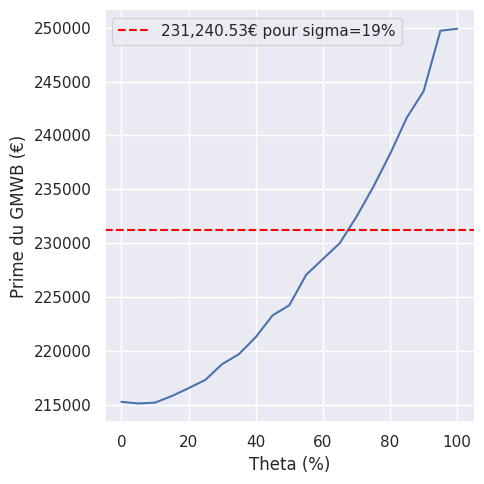

In [ ]:
#Graphique qui donne l'évolution de la prime en fonction de la part du rendement en action dans le rendement du fonds
theta_set = range(0,105,5)
courbe_dict = {'theta':theta_set, 'prime':gmwb_value}
courbe = pd.DataFrame(data = courbe_dict)
sns.set_theme()
sns.relplot(data = courbe, x = "theta", y = "prime", kind="line")
plt.xlabel("Theta (%)")
plt.ylabel("Prime du GMWB (€)")
plt.axhline(y=231240.53, color='red', linestyle='--', linewidth=1.5, label = "231,240.53€ pour sigma=19%")
plt.legend()

In [ ]:
#Ce code permet de décider du theta optimal à partir des ratio de Sharpe
# Vecteur des ratio de sharpe
sharpe_ratio = np.zeros(21)
theta = 0
for k in range(21):
  poids = np.array([theta, (1-theta)])
  total_return = np.dot(poids.T, annual_return)
  total_volatility = np.sqrt(np.dot(poids.T, np.dot(cov_matrix, poids)))
  sharpe_ratio[k] = (total_return-InterestRate)/total_volatility
  theta = theta + 0.05


Text(-0.30555555555554825, 0.5, 'Ratio de Sharpe')

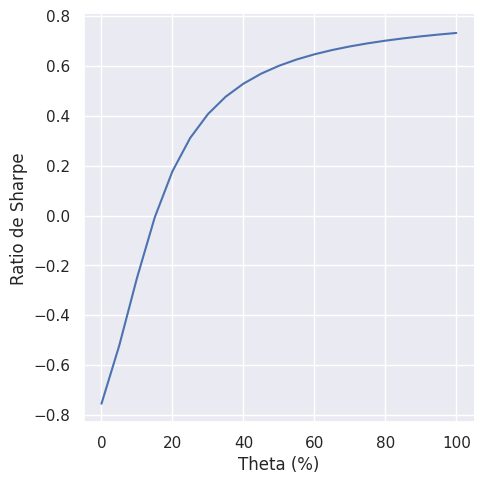

In [ ]:
#Représentation des ratio de sharpe en fonction de theta
sharpe_curve = pd.DataFrame({"theta":theta_set, "sharpe_ratio":sharpe_ratio})
sns.set_theme()
sns.relplot(data = sharpe_curve, x = "theta", y = "sharpe_ratio", kind = "line")
plt.xlabel("Theta (%)")
plt.ylabel("Ratio de Sharpe")